## 자전거 대여 수요 예측 - Bike Sharing Demand
- 데이터 클렌징 및 가공과 시각화
- 로그 변환, 피처 인코딩과 모델 학습/예측/평가

- datetime: 대여가 이루어진 날짜와 시간
- season: 계절 (봄, 여름, 가을, 겨울 등을 나타내는 숫자)
- holiday: 휴일 여부 (1: 휴일, 0: 비휴일)
- workingday: 근무일 여부 (1: 근무일, 0: 휴무일)
- weather: 날씨 상태 (1: 맑음, 2: 약간의 구름, 3: 비 또는 눈, 4: 많은 비 또는 눈)
- temp: 온도
- atemp: 체감 온도
- humidity: 상대 습도
- windspeed: 풍속
- casual: 비등록 사용자가 대여한 자전거 수
- registered: 등록 사용자가 대여한 자전거 수
- count: 총 대여한 자전거 수 (casual + registered)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
bike_df = pd.read_csv('/content/drive/MyDrive/kdt_jyg/workspace/m5_머신러닝/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [39]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
  # 1. 누락된 값 처리
  df.dropna(inplace=True)

  # 2. 날짜 및 시간 변수 처리
  df['datetime'] = pd.to_datetime(df['datetime'])
  df['hour'] = df['datetime'].dt.hour
  df['day'] = df['datetime'].dt.day
  df['month'] = df['datetime'].dt.month
  df['year'] = df['datetime'].dt.year

  # 3. 특성 스케일링
  scaler = StandardScaler()
  numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
  df[numerical_features] = scaler.fit_transform(df[numerical_features])

  # 4. 이상치 처리 (예: Z-score를 사용한 이상치 제거)
  z_score_threshold = 3
  df = df[(df[numerical_features] < z_score_threshold).all(axis=1)]

  return df

In [41]:
bike_df = preprocess_data(bike_df)

In [50]:
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import numpy as np

# 각 타겟 변수에 대한 엘라스틱넷 모델 학습 및 예측 함수
def train_and_predict_elasticnet(X_train, y_train, X_test, alpha=1.0, l1_ratio=0.7):
  model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return y_pred, model

# 그래프 그리기 함수
def plot_histogram(ax, y_pred, title):
  sns.histplot(y_pred, kde=True, color='blue', bins=50, ax=ax)
  ax.set_title(title)
  ax.set_xlabel('Predicted Demand')
  ax.set_ylabel('Frequency')

# 선형 회귀 분석 결과 출력 함수
def print_linear_eval(model, X, y):
  neg_mse_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
  avg_rmse = np.mean(np.sqrt(-neg_mse_scores))
  print('최적값 5폴드 세트의 평균 RMSE: {:3f}'.format(avg_rmse))

Evaluate for casual
최적값 5폴드 세트의 평균 RMSE: 38.298166
Evaluate for registered
최적값 5폴드 세트의 평균 RMSE: 141.804440
Evaluate for count
최적값 5폴드 세트의 평균 RMSE: 163.446216


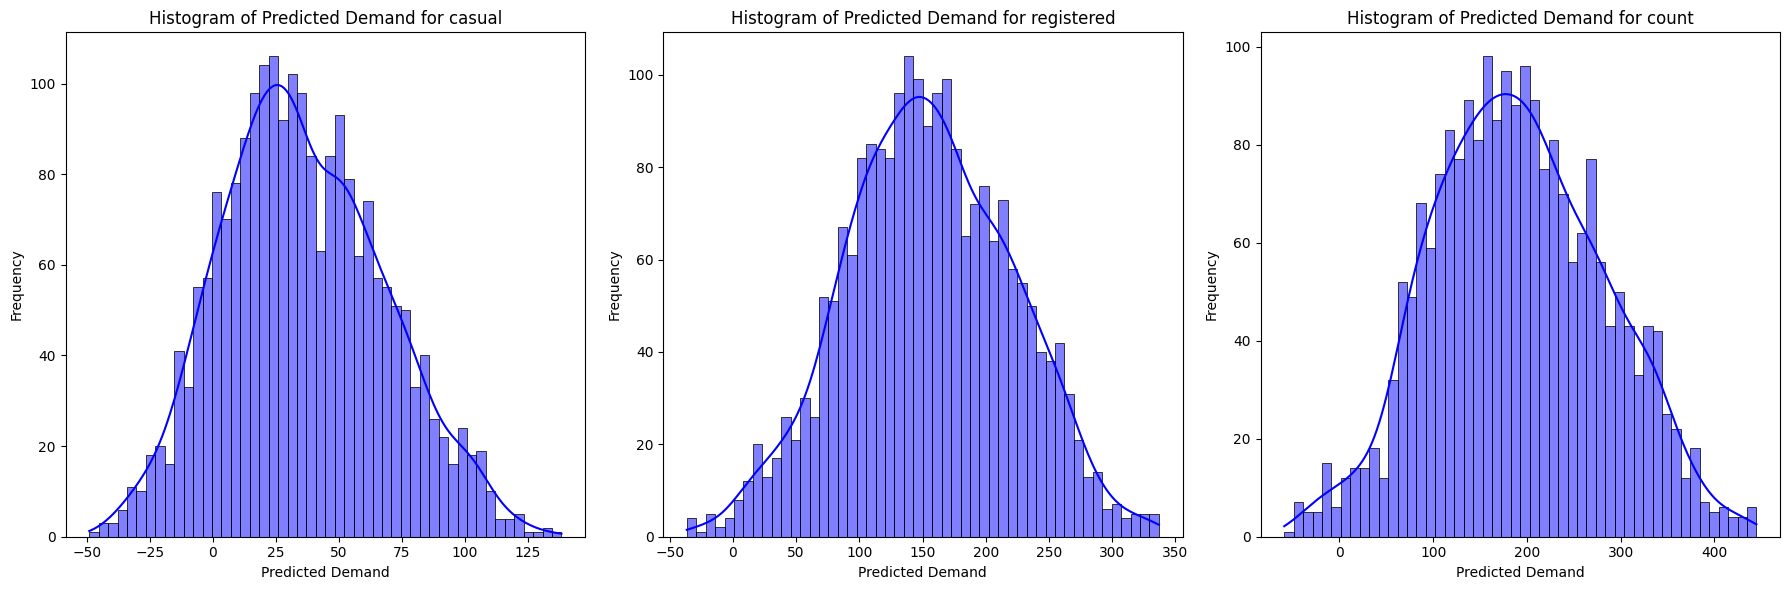

In [52]:
import warnings
warnings.filterwarnings('ignore')

# 예측을 위한 특성 선택
# feature_variables = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'hour', 'day', 'month', 'year']
feature_variables = ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity']

# 1x3 서브플롯 생성
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 각 타겟 변수에 대해 예측 모델 학습 및 그래프 그리기
for i, target in enumerate(['casual', 'registered', 'count']):
  y_target = bike_df[target]

  # 데이터 전처리
  X = bike_df[feature_variables].values  # 데이터프레임을 NumPy 배열로 변환
  X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)
  # 엘라스틱넷 모델 학습 및 예측
  elasticnet = ElasticNet()
  param_grid = {'alpha': [0.1, 0.5, 1.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
  grid_search = GridSearchCV(elasticnet, param_grid, scoring='neg_mean_squared_error', cv=5)
  grid_search.fit(X_train, y_train)
  best_elasticnet = grid_search.best_estimator_

  y_pred, model = train_and_predict_elasticnet(X_train, y_train, X_test, alpha=best_elasticnet.alpha, l1_ratio=best_elasticnet.l1_ratio)

  # 예측값에 대한 히스토그램 그리기
  plot_histogram(axes[i], y_pred, f'Histogram of Predicted Demand for {target}')

  # 평가값 출력
  print(f'Evaluate for {target}')
  print_linear_eval(model, X, y_target)
  print("="*58)

# 서브플롯 간의 간격 조정
plt.tight_layout()
plt.show()